### Data Cleaning

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

# Load dataset
df = pd.read_csv("Retail_Transactions_Dataset.csv")

# Peek at the data
print("Shape:", df.shape)
print("Columns:", df.columns)
df.head()

Shape: (20000, 13)
Columns: Index(['Transaction_ID', 'Date', 'Customer_Name', 'Product', 'Total_Items',
       'Total_Cost', 'Payment_Method', 'City', 'Store_Type',
       'Discount_Applied', 'Customer_Category', 'Season', 'Promotion'],
      dtype='object')


,Transaction_ID,Date,Customer_Name,Product,Total_Items,Total_Cost,Payment_Method,City,Store_Type,Discount_Applied,Customer_Category,Season,Promotion
0,1000987231,2023-05-23 18:07:20,Jacqueline Maynard,"['Pancake Mix', 'Coffee', 'Ice Cream']",3,16.63,Credit Card,Houston,Specialty Store,True,Middle-Aged,Winter,NaN
1,1000079954,2022-03-10 16:47:15,David White,['Cleaning Spray'],5,7.46,Debit Card,Miami,Supermarket,False,Middle-Aged,Fall,BOGO (Buy One Get One)
2,1000567130,2022-07-22 17:02:17,Dr. Thomas Edwards,"['Salmon', 'Garden Hose', 'Deodorant', 'Air Fr...",9,52.27,Cash,Boston,Warehouse Club,True,Teenager,Fall,BOGO (Buy One Get One)
3,1000500891,2022-04-21 15:14:38,Kristin Collins,"['Power Strips', 'Tuna']",5,25.44,Cash,Los Angeles,Convenience Store,False,Homemaker,Spring,NaN
4,1000055399,2023-05-03 05:26:02,Robert Finley,"['Cereal', 'Cheese', 'Yogurt', 'Sponges', 'Chi...",6,86.05,Credit Card,Atlanta,Pharmacy,False,Professional,Fall,BOGO (Buy One Get One)


In [2]:
# Convert Date column to datetime
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

In [3]:
# Fill missing promotions
df['Promotion'] = df['Promotion'].fillna("No Promotion")

In [4]:
# Check missing values
print(df.isnull().sum())

Transaction_ID       0
Date                 0
Customer_Name        0
Product              0
Total_Items          0
Total_Cost           0
Payment_Method       0
City                 0
Store_Type           0
Discount_Applied     0
Customer_Category    0
Season               0
Promotion            0
dtype: int64


In [5]:
# General missing value handling

# Fill missing numeric values with median
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
for col in num_cols:
    df[col] = df[col].fillna(df[col].median())

# Fill missing categorical values with mode
cat_cols = df.select_dtypes(include=['object']).columns
for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

In [6]:
# Remove duplicates
df.drop_duplicates(inplace=True)

In [7]:
# Function to remove outliers using IQR
def remove_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return data[(data[column] >= lower) & (data[column] <= upper)]

# Apply outlier removal on important numeric columns
df = remove_outliers_iqr(df, 'Total_Cost')
df = remove_outliers_iqr(df, 'Total_Items')

In [8]:
# Normalize important numerical features
scaler = StandardScaler()
df[['Total_Cost', 'Total_Items']] = scaler.fit_transform(df[['Total_Cost', 'Total_Items']])

# check
print("After cleaning:", df.shape)
print(df.describe())

After cleaning: (20000, 13)
       Transaction_ID                           Date   Total_Items  \
count    2.000000e+04                          20000  2.000000e+04   
mean     1.000499e+09  2022-03-09 19:54:32.910899968 -7.460699e-18   
min      1.000000e+09            2020-01-01 00:20:46 -1.563305e+00   
25%      1.000249e+09            2021-02-02 08:37:16 -8.683869e-01   
50%      1.000499e+09     2022-03-09 14:57:02.500000  1.739901e-01   
75%      1.000751e+09  2023-04-12 23:47:20.750000128  8.689081e-01   
max      1.001000e+09            2024-05-18 18:39:58  1.563826e+00   
std      2.889301e+05                            NaN  1.000025e+00   

         Total_Cost  
count  2.000000e+04  
mean   3.332445e-16  
min   -1.752550e+00  
25%   -8.688053e-01  
50%   -4.112993e-04  
75%    8.654243e-01  
max    1.718833e+00  
std    1.000025e+00  


### Clustering Analysis

In [9]:
# Create Recency, Frequency, Monetary (RFM) metrics

# Convert Date column to datetime
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Define a reference date (most recent date in dataset)
ref_date = df['Date'].max()

# Group by Customer (use Customer_Name instead of Customer_ID)
rfm = df.groupby('Customer_Name').agg({
    'Date': lambda x: (ref_date - x.max()).days,  # Recency
    'Transaction_ID': 'count',                    # Frequency
    'Total_Cost': 'sum'                           # Monetary
}).reset_index()

# Rename columns
rfm.columns = ['Customer_Name', 'Recency', 'Frequency', 'Monetary']


print(rfm.head())

   Customer_Name  Recency  Frequency  Monetary
0   Aaron Adkins     1237          1  0.857018
1  Aaron Aguilar      622          1 -1.097234
2    Aaron Baker      642          2 -2.522308
3   Aaron Barnes     1312          1 -0.891831
4  Aaron Bennett      179          1  0.780266


In [10]:
# cale the RFM features
scaler = StandardScaler()
X = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

print("Scaled data shape:", X.shape)

Scaled data shape: (17829, 3)


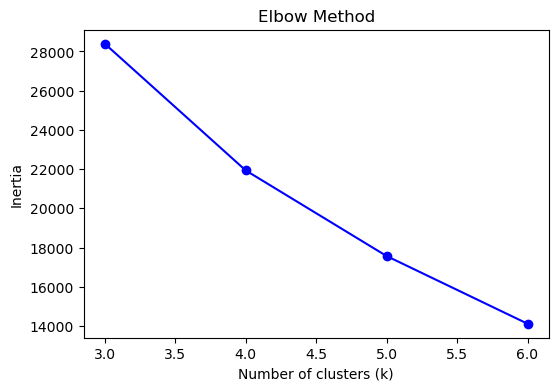

In [11]:
# Elbow method to choose best k
inertia = []
K = range(3, 7)  # test k=3 to 6

for k in K:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X)
    inertia.append(km.inertia_)

# Plot elbow
plt.figure(figsize=(6,4))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

In [12]:
# Silhouette score validation
sil_scores = {}

for k in K:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X)
    score = silhouette_score(X, labels)
    sil_scores[k] = score
    print(f"Silhouette score for k={k}: {score:.4f}")

# Select best k
best_k = max(sil_scores, key=sil_scores.get)
print("Best k selected:", best_k)

Silhouette score for k=3: 0.3487
Silhouette score for k=4: 0.3563
Silhouette score for k=5: 0.3758
Silhouette score for k=6: 0.3858
Best k selected: 6


In [13]:
# Apply final KMeans clustering
final_kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
rfm['Cluster'] = final_kmeans.fit_predict(X)

print(rfm['Cluster'].value_counts())
rfm.head()

Cluster
1    4151
0    4070
4    4054
3    4010
2    1432
5     112
Name: count, dtype: int64


,Customer_Name,Recency,Frequency,Monetary,Cluster
0,Aaron Adkins,1237,1,0.857018,1
1,Aaron Aguilar,622,1,-1.097234,0
2,Aaron Baker,642,2,-2.522308,2
3,Aaron Barnes,1312,1,-0.891831,4
4,Aaron Bennett,179,1,0.780266,3


In [14]:
# Cluster summary to create personas
cluster_summary = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'Customer_Name': 'count'
}).rename(columns={'Customer_ID':'Num_Customers'}).reset_index()

print(cluster_summary)

   Cluster      Recency  Frequency  Monetary  Customer_Name
0        0   394.514251   1.000246 -0.853832           4070
1        1  1196.734763   1.004577  0.865029           4151
2        2   490.331006   2.176676 -0.042810           1432
3        3   399.133416   1.001496  0.875096           4010
4        4  1204.367045   1.006413 -0.880192           4054
5        5   291.812500   4.875000  0.043097            112


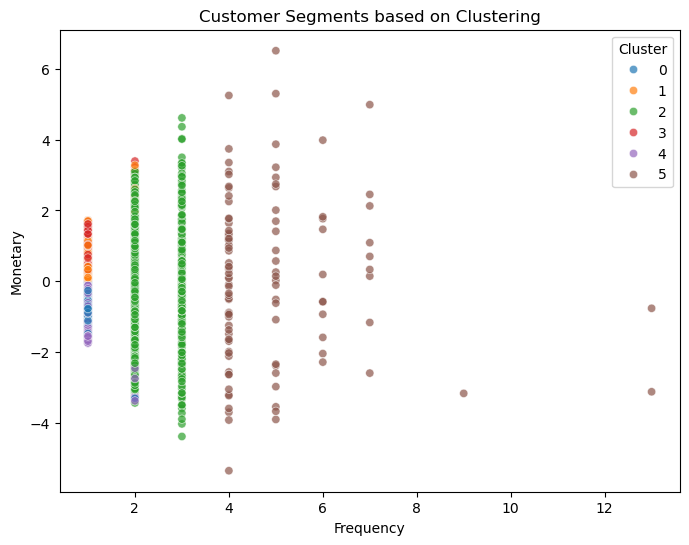

In [15]:
# Visualize clusters (2D plot)
plt.figure(figsize=(8,6))
sns.scatterplot(data=rfm, x='Frequency', y='Monetary', hue='Cluster', palette='tab10', alpha=0.7)
plt.title("Customer Segments based on Clustering")
plt.show()

### Reporting & Visualization

In [16]:
# Plot style
sns.set(style="whitegrid", palette="muted", font_scale=1.1)

C:\Users\YASEEN\AppData\Local\Temp\ipykernel_13848\2254597547.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Cluster", data=rfm, palette="tab10")


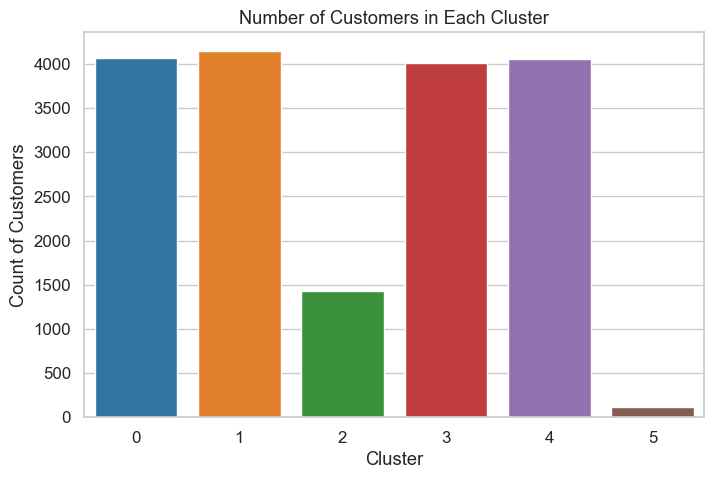

In [17]:
# Cluster Distribution (Bar Plot)
plt.figure(figsize=(8,5))
sns.countplot(x="Cluster", data=rfm, palette="tab10")
plt.title("Number of Customers in Each Cluster")
plt.xlabel("Cluster")
plt.ylabel("Count of Customers")
plt.show()

C:\Users\YASEEN\AppData\Local\Temp\ipykernel_13848\2399773941.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Cluster", y="Recency", data=rfm, ax=axes[0], palette="tab10")
C:\Users\YASEEN\AppData\Local\Temp\ipykernel_13848\2399773941.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Cluster", y="Frequency", data=rfm, ax=axes[1], palette="tab10")
C:\Users\YASEEN\AppData\Local\Temp\ipykernel_13848\2399773941.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Cluster", y="Monetary", data=rfm, ax=axes[2], palette="tab10")


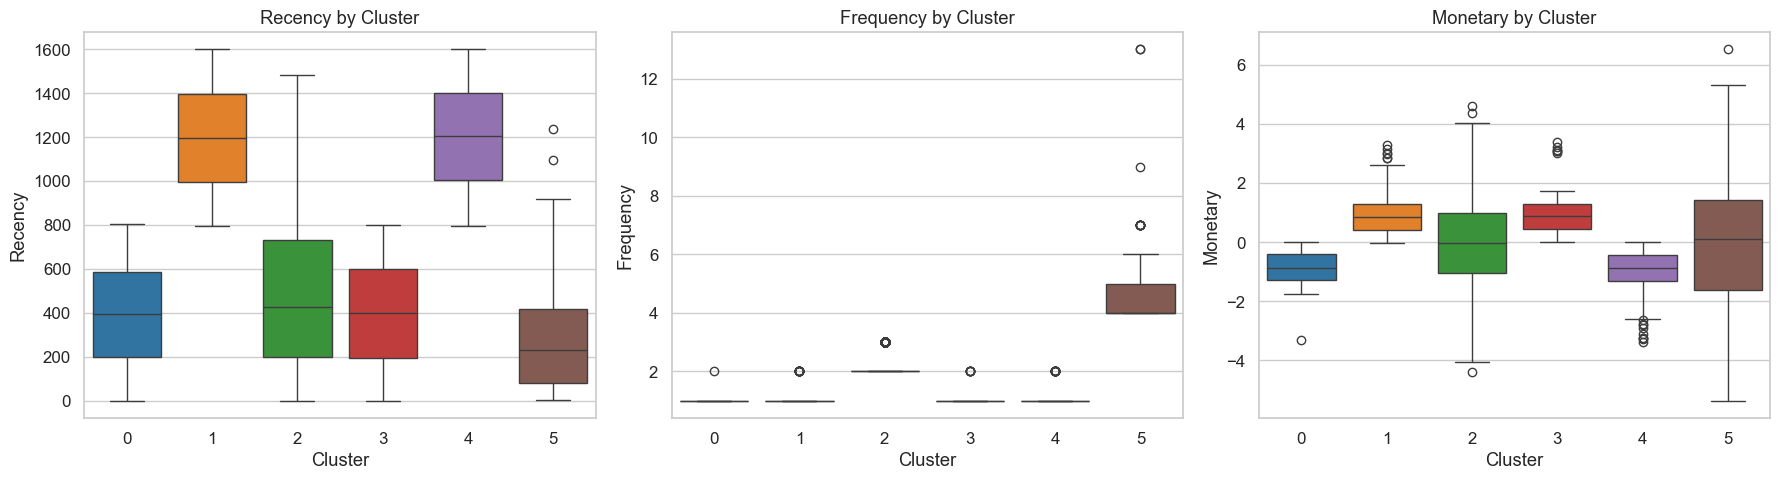

In [18]:
# Boxplots for RFM Metrics per Cluster

fig, axes = plt.subplots(1, 3, figsize=(18,5))

sns.boxplot(x="Cluster", y="Recency", data=rfm, ax=axes[0], palette="tab10")
axes[0].set_title("Recency by Cluster")

sns.boxplot(x="Cluster", y="Frequency", data=rfm, ax=axes[1], palette="tab10")
axes[1].set_title("Frequency by Cluster")

sns.boxplot(x="Cluster", y="Monetary", data=rfm, ax=axes[2], palette="tab10")
axes[2].set_title("Monetary by Cluster")

plt.tight_layout()
plt.show()

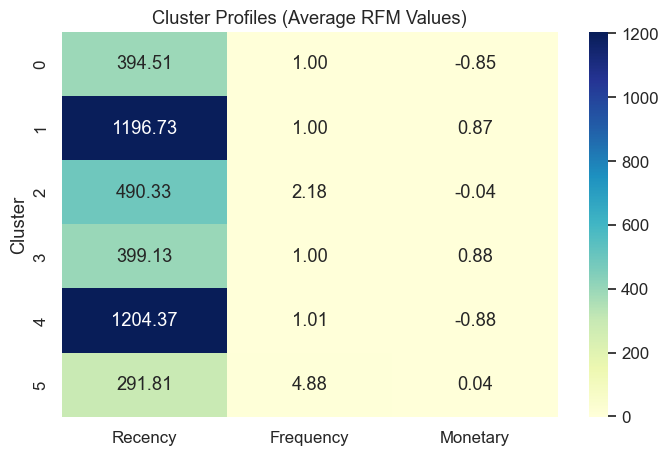

In [19]:
# Heatmap of Average RFM Values by Cluster

cluster_summary = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean'
}).reset_index()

plt.figure(figsize=(8,5))
sns.heatmap(cluster_summary.set_index("Cluster"), annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Cluster Profiles (Average RFM Values)")
plt.show()

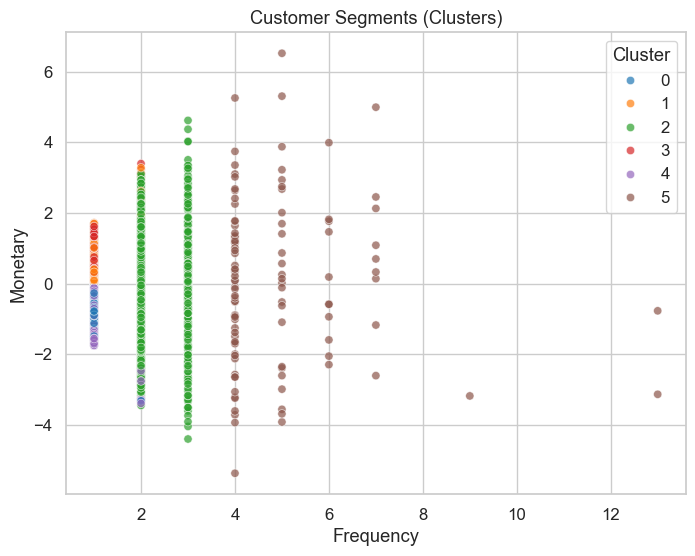

In [20]:
# 2D Scatter Plot (Frequency vs Monetary)

plt.figure(figsize=(8,6))
sns.scatterplot(data=rfm, x="Frequency", y="Monetary", hue="Cluster", palette="tab10", alpha=0.7)
plt.title("Customer Segments (Clusters)")
plt.show()


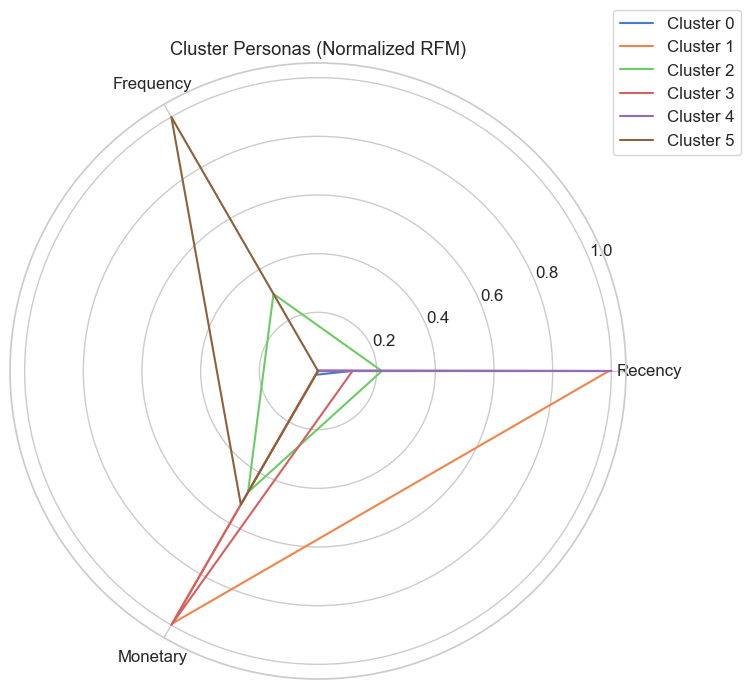

In [21]:
# Radar Chart for Cluster Personas

from math import pi

# Normalize summary for visualization
persona = cluster_summary.copy()
cols = ['Recency','Frequency','Monetary']
persona[cols] = (persona[cols] - persona[cols].min()) / (persona[cols].max() - persona[cols].min())

# Radar chart setup
categories = cols
N = len(categories)

angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

plt.figure(figsize=(8,8))

for i in range(len(persona)):
    values = persona.loc[i, categories].tolist()
    values += values[:1]
    plt.polar(angles, values, label=f"Cluster {persona['Cluster'][i]}")

plt.xticks(angles[:-1], categories)
plt.title("Cluster Personas (Normalized RFM)")
plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1.1))
plt.show()